In [2]:
import astropy
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, CartesianDifferential, solar_system_ephemeris, get_body_barycentric
from astropy.time import Time
from astropy.constants import c
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import scipy.interpolate

Converting AltAz to RA DEC and finding the radial velocity correction

In [3]:
alt = 57.66 * u.deg
az = 179.99 * u.deg
jodrell_bank = EarthLocation(lat=53.234329 * u.deg, lon=-2.3050403 * u.deg, height=77 * u.m)
obstime = Time('2024-07-18T09:50:54')

altaz = AltAz(alt=alt, az=az, location=jodrell_bank, obstime=obstime)

skycoord = SkyCoord(altaz)

with solar_system_ephemeris.set('builtin'):
    barycorr = skycoord.radial_velocity_correction(kind="barycentric").to(u.km/u.s)

v_sun = CartesianDifferential([0.28999706839034606, -17.317264789717928, 10.00141199546947] * u.km/u.s)

galactic = skycoord.transform_to('galactic')

l = galactic.l.radian
b = galactic.b.radian
unit_vector = np.array([np.cos(b) * np.cos(l), np.cos(b) * np.sin(l), np.sin(b)])

v_sun_los = np.dot(v_sun.d_xyz.value, unit_vector) * u.km/u.s

lsr_corr = barycorr + v_sun_los

print(f'RA: {skycoord.icrs.ra.to_string(unit=u.hour, sep=":", pad=True)}')
print(f'Dec: {skycoord.icrs.dec.to_string(unit=u.deg, sep=":", pad=True)}')
print(skycoord.icrs.ra.deg,skycoord.icrs.dec.deg)
print(f'Radial Velocity correction to barycentre: {barycorr}')
print(f'Radial Velocity correction to LSR: {lsr_corr}')

RA: 05:27:03.7791
Dec: 20:52:22.9944
81.76574635181774 20.873053993789906
Radial Velocity correction to barycentre: 16.30347282174339 km / s
Radial Velocity correction to LSR: 16.018235447689403 km / s


Comparing Shinichiro's data with LAB data, exploring how beamwidth and elevation accuracy affect the profile

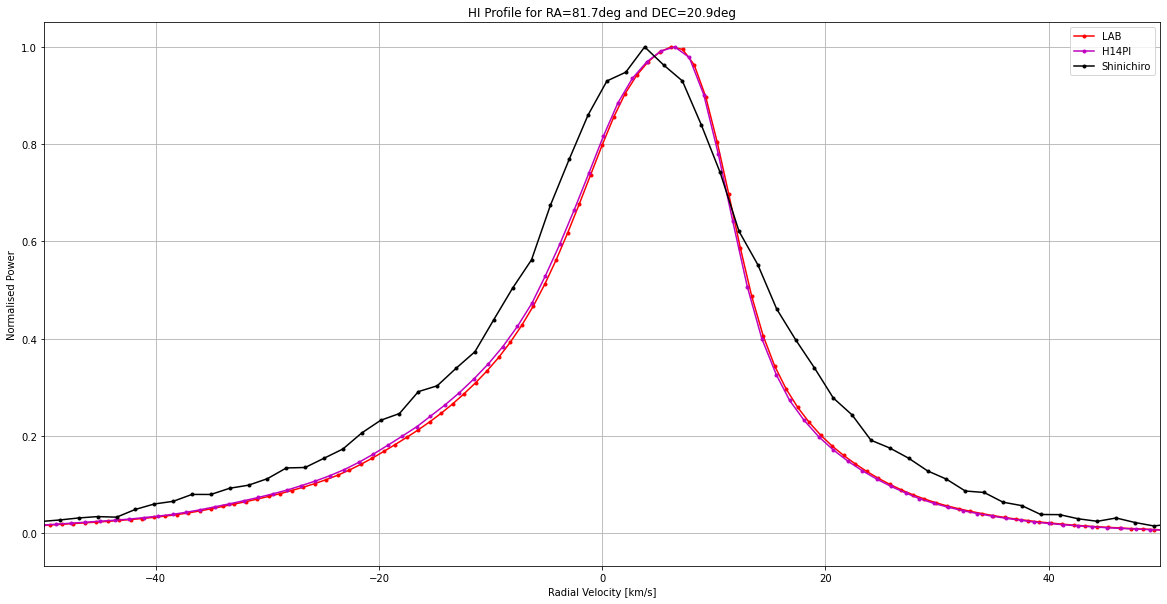

Difference between peak positions: [2.375] [2.695] km/s
Resolution of LAB, Shinichiro, H14PI data: 1.0304896907216496 1.69 1.2881974248927037
[1.74600919]


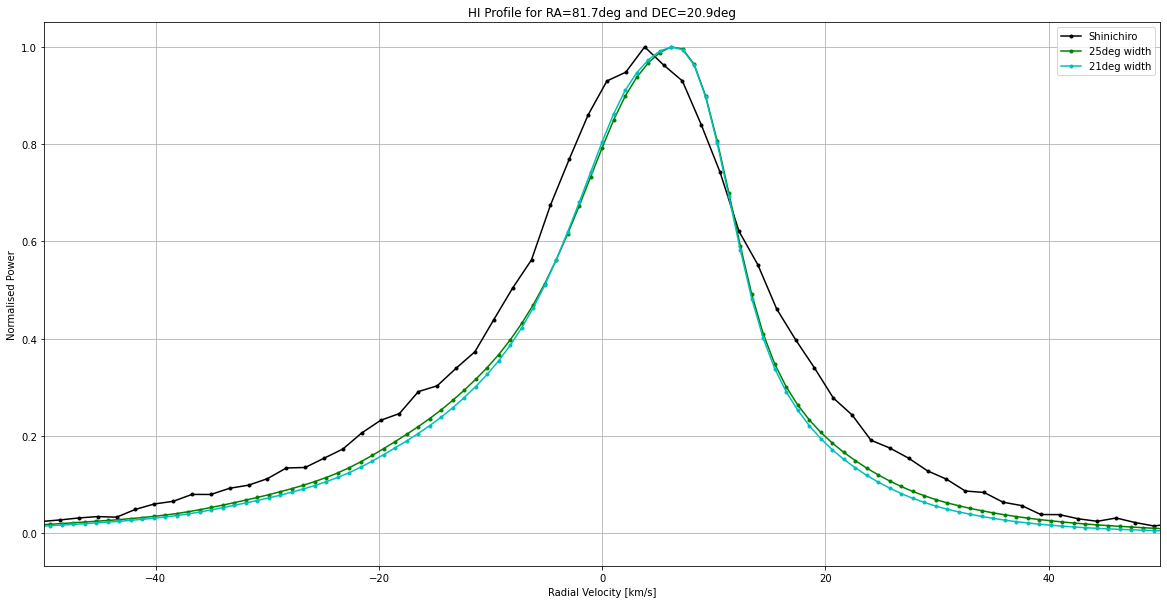

Difference between peak positions (21deg): [2.375] km/s
Difference between peak positions (25deg): [2.375] km/s


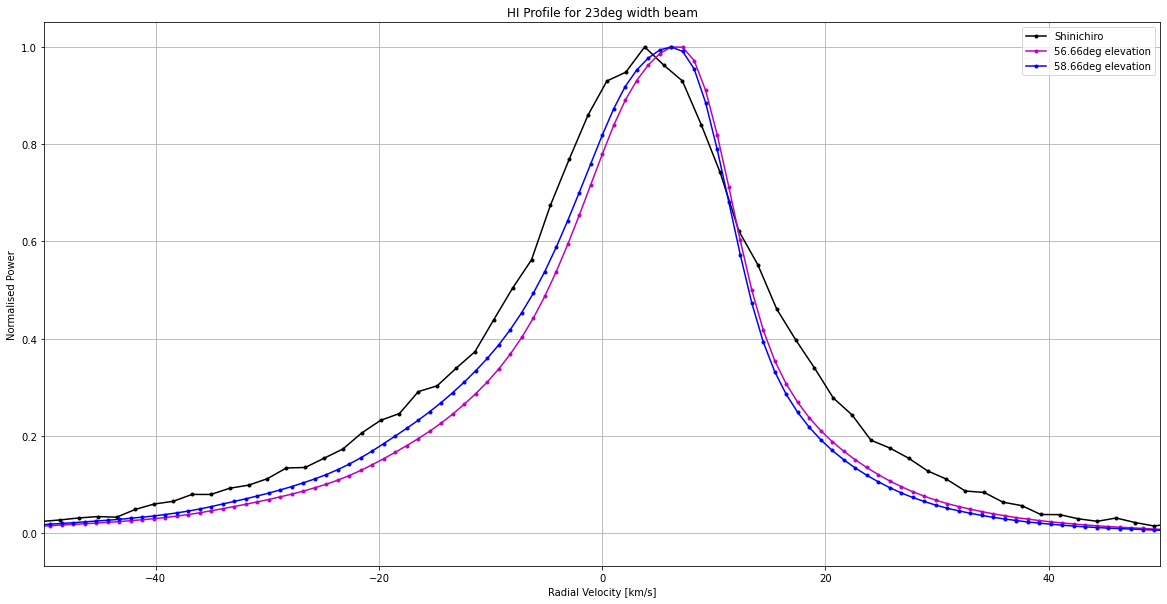

Difference between peak positions (58.66deg): [2.375] km/s
Difference between peak positions (56.66deg): [2.375] km/s


In [4]:
lab_data = np.genfromtxt("data/hydrogen profiles/spectrum 23deg 57.66el.txt", skip_header=4)
sc_data = np.genfromtxt("data/hydrogen profiles/20240718T105054_Vlsr.xlsx - 20240718T105054.csv", skip_header=1, delimiter=',')

deg25_data = np.genfromtxt("data/hydrogen profiles/spectrum 25deg 57.66el.txt", skip_header=4)
deg21_data = np.genfromtxt("data/hydrogen profiles/spectrum 21deg 57.66el.txt", skip_header=4)
el56_data = np.genfromtxt("data/hydrogen profiles/spectrum 23deg 56.66el.txt", skip_header=4)
el58_data = np.genfromtxt("data/hydrogen profiles/spectrum 23deg 58.66el.txt", skip_header=4)

lab_vel = lab_data[:,0]
lab_pwr = lab_data[:,1] / np.max(lab_data[:,1])
sc_vel = sc_data[0:255,3]
sc_pwr = sc_data[0:255,8]

deg25_vel = deg25_data[:,0]
deg25_pwr = deg25_data[:,1] / np.max(deg25_data[:,1])
deg21_vel = deg21_data[:,0]
deg21_pwr = deg21_data[:,1] / np.max(deg21_data[:,1])
el56_vel = el56_data[:,0]
el56_pwr = el56_data[:,1] / np.max(el56_data[:,1])
el58_vel = el58_data[:,0]
el58_pwr = el58_data[:,1] / np.max(el58_data[:,1])

h14pi_data = np.genfromtxt("data/hydrogen profiles/spectra h14pi 57.66el.csv", skip_header=2, delimiter=',')
h14pi_vel = h14pi_data[:,0]
h14pi_23deg_pwr = h14pi_data[:,1] / np.max(h14pi_data[:,1])
h14pi_10deg_pwr = h14pi_data[:,2] / np.max(h14pi_data[:,2])

plt.figure(figsize=(20, 10))
plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
plt.plot(h14pi_vel , h14pi_23deg_pwr, marker=".", color='m', label="H14PI")
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for RA=81.7deg and DEC=20.9deg")
plt.xlim(-50,50)
plt.show()

lab_pk = lab_vel[np.where(lab_pwr == np.max(lab_pwr))]
sc_pk = sc_vel[np.where(sc_pwr == np.max(sc_pwr))]
h14pi_pk = h14pi_vel[np.where(h14pi_23deg_pwr == np.max(h14pi_23deg_pwr))]
pk_dif_1 = lab_pk-sc_pk
pk_dif_2 = h14pi_pk-sc_pk
print("Difference between peak positions:", pk_dif_1, pk_dif_2, "km/s")

lab_res = np.abs(np.sum(np.diff(lab_vel))/(len(lab_vel)-1))
sc_res = np.abs(np.sum(np.diff(sc_vel))/(len(sc_vel)-1))
h14pi_res = np.abs(np.sum(np.diff(h14pi_vel))/(len(h14pi_vel)-1))
print("Resolution of LAB, Shinichiro, H14PI data:", lab_res, sc_res, h14pi_res)

print(pk_dif_1/((lab_res/2)+(sc_res/2)))

plt.figure(figsize=(20, 10))
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.plot(deg25_vel, deg25_pwr, marker=".", color='g', label="25deg width")
plt.plot(deg21_vel, deg21_pwr, marker=".", color='c', label="21deg width")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for RA=81.7deg and DEC=20.9deg")
plt.xlim(-50,50)
plt.show()

deg25_pk = deg25_vel[np.where(deg25_pwr == np.max(deg25_pwr))]
deg21_pk = deg21_vel[np.where(deg21_pwr == np.max(deg21_pwr))]
sc_pk = sc_vel[np.where(sc_pwr == np.max(sc_pwr))]
deg25_pk_dif = deg25_pk-sc_pk
deg21_pk_dif = deg25_pk-sc_pk
print("Difference between peak positions (21deg):", deg21_pk_dif, "km/s")
print("Difference between peak positions (25deg):", deg25_pk_dif, "km/s")

plt.figure(figsize=(20, 10))
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.plot(el56_vel, el56_pwr, marker=".", color='m', label="56.66deg elevation")
plt.plot(el58_vel, el58_pwr, marker=".", color='b', label="58.66deg elevation")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 23deg width beam")
plt.xlim(-50,50)
plt.show()

el56_pk = el56_vel[np.where(el56_pwr == np.max(el56_pwr))]
el58_pk = el58_vel[np.where(el58_pwr == np.max(el58_pwr))]
sc_pk = sc_vel[np.where(sc_pwr == np.max(sc_pwr))]
el56_pk_dif = el56_pk-sc_pk
el58_pk_dif = el58_pk-sc_pk
print("Difference between peak positions (58.66deg):", el58_pk_dif, "km/s")
print("Difference between peak positions (56.66deg):", el56_pk_dif, "km/s")



Comparing LAB data convolved to different beam sizes

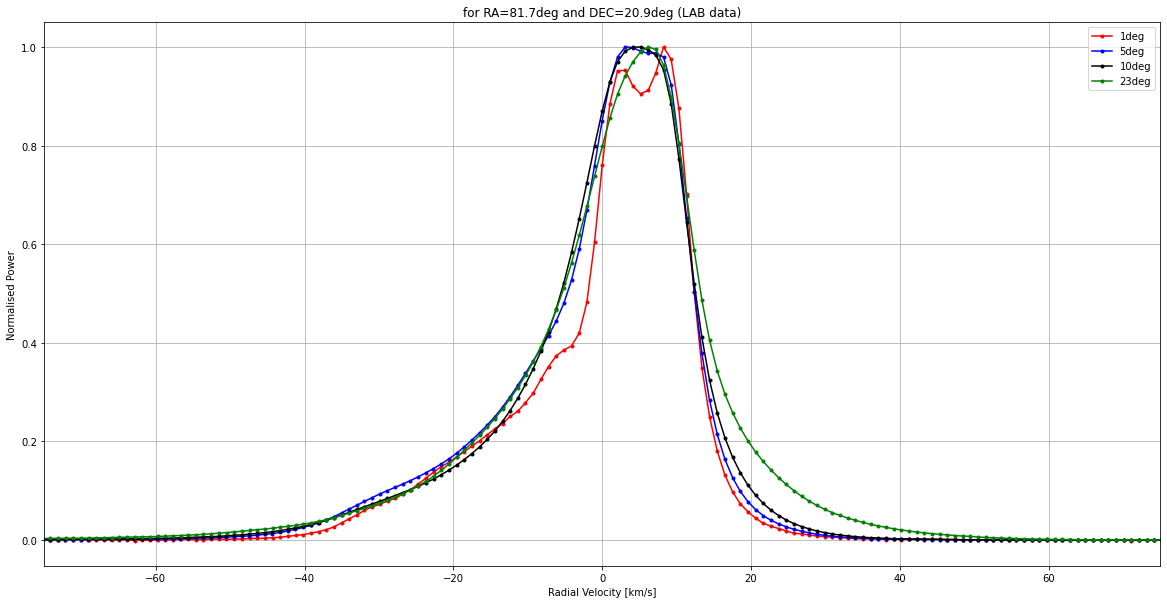

[8.24] [3.09] [5.15] [6.18]


In [5]:
deg1_data = np.genfromtxt("data/hydrogen profiles/spectrum 1deg 57.66el.txt", skip_header=4)
deg5_data = np.genfromtxt("data/hydrogen profiles/spectrum 5deg 57.66el.txt", skip_header=4)
deg10_data = np.genfromtxt("data/hydrogen profiles/spectrum 10deg 57.66el.txt", skip_header=4)

deg1_vel = deg1_data[:,0]
deg1_pwr = deg1_data[:,1] / np.max(deg1_data[:,1])
deg5_vel = deg5_data[:,0]
deg5_pwr = deg5_data[:,1] / np.max(deg5_data[:,1])
deg10_vel = deg10_data[:,0]
deg10_pwr = deg10_data[:,1] / np.max(deg10_data[:,1])

plt.figure(figsize=(20, 10))
plt.plot(deg1_vel, deg1_pwr, marker=".", color='r', label="1deg")
plt.plot(deg5_vel, deg5_pwr, marker=".", color='b', label="5deg")
plt.plot(deg10_vel, deg10_pwr, marker=".", color='k', label="10deg")
plt.plot(lab_vel, lab_pwr, marker=".", color='g', label="23deg")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("for RA=81.7deg and DEC=20.9deg (LAB data)")
plt.xlim(-75,75)
plt.show()

deg1_pk = deg1_vel[np.where(deg1_pwr == np.max(deg1_pwr))]
deg5_pk = deg5_vel[np.where(deg5_pwr == np.max(deg5_pwr))]
deg10_pk = deg10_vel[np.where(deg10_pwr == np.max(deg10_pwr))]

print(deg1_pk, deg5_pk, deg10_pk, lab_pk)

Comparing LAB and H14PI data convolved to different beam sizes

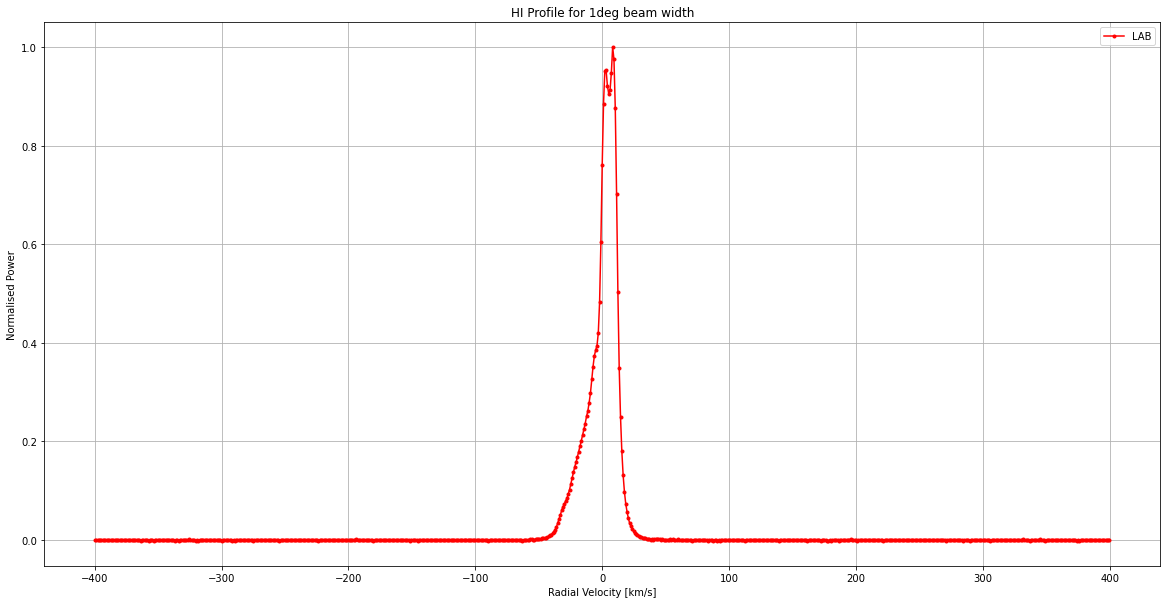

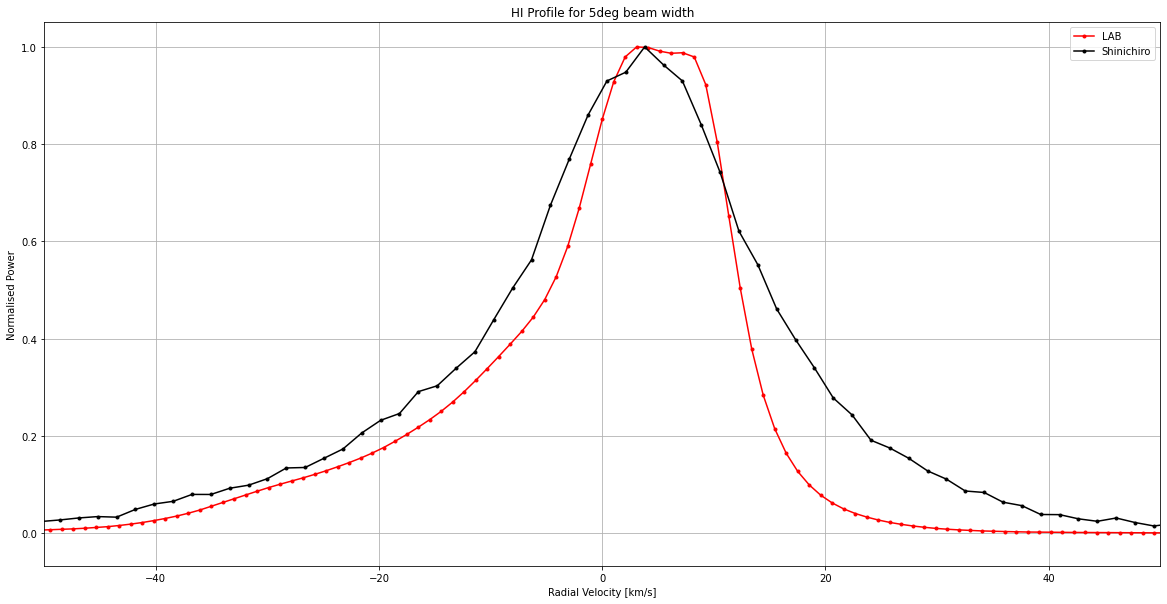

[-0.715]


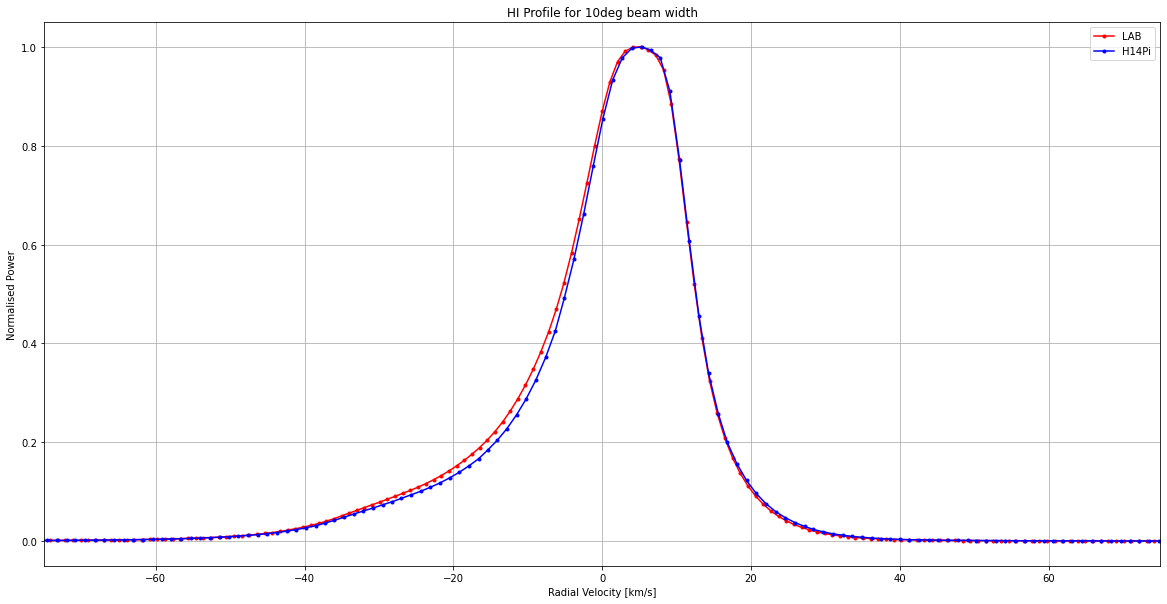

[0.15]


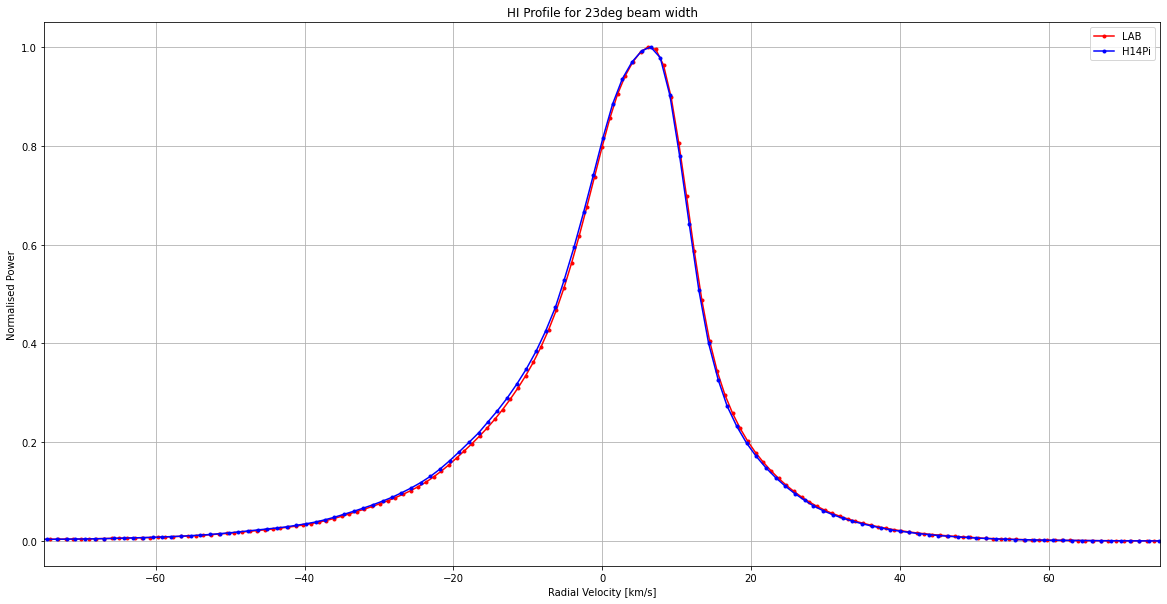

[0.32]


In [6]:
plt.figure(figsize=(20, 10))
plt.plot(deg1_vel, deg1_pwr, marker=".", color='r', label="LAB")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 1deg beam width")
plt.show()

plt.figure(figsize=(20, 10)) 
plt.plot(deg5_vel, deg5_pwr, marker=".", color='r', label="LAB")
plt.plot(sc_vel, sc_pwr, marker=".", color='k', label='Shinichiro')
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 5deg beam width")
plt.xlim(-50, 50)
plt.show()

print(deg5_pk-sc_pk)

plt.figure(figsize=(20, 10))
plt.plot(deg10_vel, deg10_pwr, marker=".", color='r', label="LAB")
plt.plot(h14pi_vel, h14pi_10deg_pwr, marker=".", color='b', label="H14Pi")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 10deg beam width")
plt.xlim(-75,75)
plt.show()

h14pi_deg10_pk = h14pi_vel[np.where(h14pi_10deg_pwr == np.max(h14pi_10deg_pwr))]
print(h14pi_deg10_pk-deg10_pk)

plt.figure(figsize=(20, 10))
plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
plt.plot(h14pi_vel, h14pi_23deg_pwr, marker=".", color='b', label="H14Pi")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("HI Profile for 23deg beam width")
plt.xlim(-75,75)
plt.show()

print(h14pi_pk-lab_pk)

deg1_pk = deg1_vel[np.where(deg1_pwr == np.max(deg1_pwr))]
deg5_pk = deg5_vel[np.where(deg5_pwr == np.max(deg5_pwr))]
deg10_pk = deg10_vel[np.where(deg10_pwr == np.max(deg10_pwr))]

LSR https://www.researchgate.net/publication/227646452_Local_Kinematics_and_the_Local_Standard_of_Rest

In [7]:
print("LSR:", np.sqrt(11.1**2 + 12.24**2 + 7.25**2))
print("+/-", np.sqrt((0.74/11.1)**2 + (0.47/12.24)**2 + (0.37/7.25)**2))

LSR: 18.044115384246467
+/- 0.09232238344213324


S7
2024: RA 02:02:38 DEC 60:19:00
J2000: RA 02:00:57 DEC 60:12:06

In [8]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(f"data/{s7_transit.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        # a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

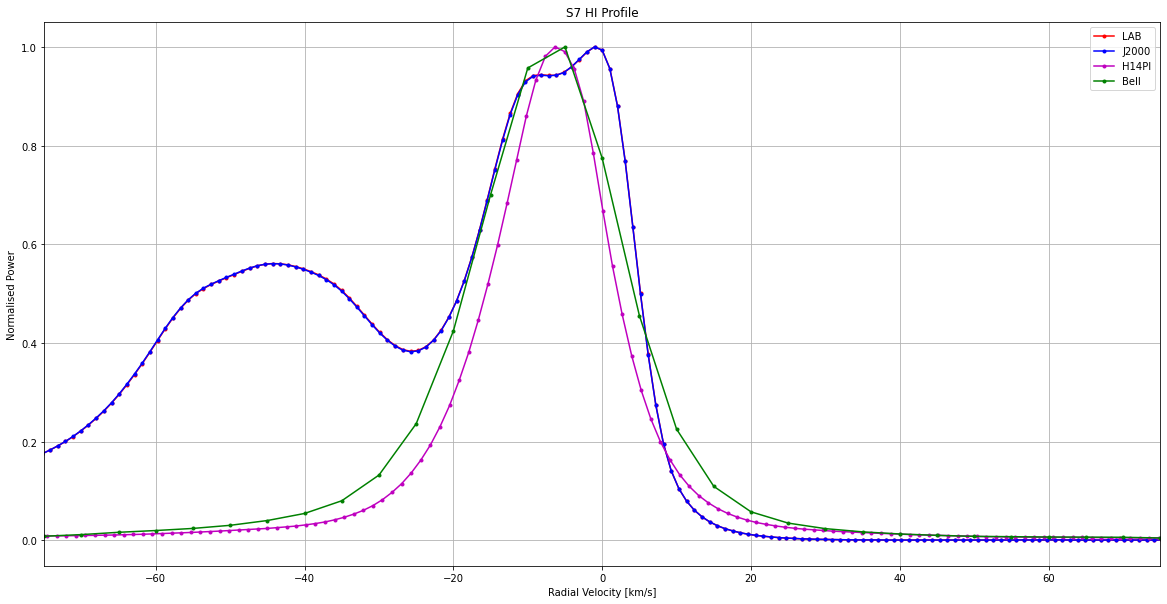

In [9]:
s7_lab = np.genfromtxt("data/hydrogen profiles/s7_lab.txt", skip_header=4)
s7_lab_j2000 = np.genfromtxt("data/hydrogen profiles/s7_lab_j2000.txt", skip_header=4)
s7_lab_vel = s7_lab[:,0]
s7_lab_j2000_vel = s7_lab_j2000[:,0]
s7_lab_pwr = s7_lab[:,1] / np.max(s7_lab[:,1])
s7_lab_j2000_pwr = s7_lab_j2000[:,1] / np.max(s7_lab_j2000[:,1])

s7_h14pi = np.genfromtxt("data/hydrogen profiles/HI4PI_S7_spectra.csv", skip_header=2, delimiter=',')
s7_h14pi_vel = s7_h14pi[:,1]
s7_h14pi_pwr = s7_h14pi[:,2] / np.max(s7_h14pi[:,2])

s7_bell = np.genfromtxt("data/hydrogen profiles/Bell_S7_spectra.csv", skip_header=2, delimiter=',')
s7_bell_vel = s7_bell[:,1]
s7_bell_pwr = s7_bell[:,2] / np.max(s7_bell[:,2])

plt.figure(figsize=(20, 10))
plt.plot(s7_lab_vel, s7_lab_pwr, marker=".", color='r', label="LAB")
plt.plot(s7_lab_j2000_vel, s7_lab_j2000_pwr, marker=".", color='b', label="J2000")
#plt.plot(s7_lab_vel, s7_lab_pwr-s7_lab_j2000_pwr, marker=".", color='k', label="Difference")
plt.plot(s7_h14pi_vel, s7_h14pi_pwr, marker=".", color='m', label="H14PI")
plt.plot(s7_bell_vel, s7_bell_pwr, marker=".", color='g', label="Bell")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("S7 HI Profile")
plt.xlim(-75,75)
plt.show()

s7_lab_vel = s7_lab_j2000_vel
s7_lab_pwr = s7_lab_j2000_pwr

In [34]:
obstime = Time('2024-08-12T18:15:18', scale='utc')
aa = AltAz(location=jodrell_bank, obstime=obstime)
s6_coord = SkyCoord(l=1.91*u.deg, b=41.42*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
s7_coord = SkyCoord('02h02m38s', '60deg19m', location=jodrell_bank, obstime=obstime)
s8_coord = SkyCoord(l=207*u.deg, b=-15*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
s9_coord = SkyCoord(l=356*u.deg, b=-4*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)

p1_coord = SkyCoord(l=20*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p2_coord = SkyCoord(l=30*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p3_coord = SkyCoord(l=40*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p4_coord = SkyCoord(l=50*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p5_coord = SkyCoord(l=60*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p6_coord = SkyCoord(l=70*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p7_coord = SkyCoord(l=340*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p8_coord = SkyCoord(l=330*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p9_coord = SkyCoord(l=320*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p10_coord = SkyCoord(l=310*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p11_coord = SkyCoord(l=300*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p12_coord = SkyCoord(l=290*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p13_coord = SkyCoord(l=210*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p14_coord = SkyCoord(l=120*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)
p15_coord = SkyCoord(l=180*u.deg, b=0*u.deg, frame='galactic', location=jodrell_bank, obstime=obstime)

#print(p1_coord.transform_to(aa))
print(p15_coord.icrs.ra.hms)
print(p15_coord.icrs.dec.dms)

with solar_system_ephemeris.set('builtin'):
    s7_barycorr = s7_coord.radial_velocity_correction(kind="barycentric").to(u.km/u.s)

#print(s7_barycorr)

#v_sun = CartesianDifferential([11.1, 12.24, 7.25] * u.km/u.s) #BINNEY
v_sun = CartesianDifferential([0.28999706839034606, -17.317264789717928, 10.00141199546947] * u.km/u.s) #ASTROPY
galactic = s7_coord.transform_to('galactic')

l = galactic.l.radian
b = galactic.b.radian
unit_vector = np.array([np.cos(b) * np.cos(l), np.cos(b) * np.sin(l), np.sin(b)])

v_sun_los = np.dot(v_sun.d_xyz.value, unit_vector) * u.km/u.s

#s7_lsr_corr = s7_barycorr + v_sun_los
#s7_lsr_corr = 13.02 * u.km/u.s #F4KLO
#s7_lsr_corr = 24.78 * u.km/u.s #RV
#s7_lsr_corr = 24.95 * u.km/u.s #GBT
s7_lsr_corr = 19.11041104110411 *u.km/u.s

#RA+11.7deg=02h49m26s GBT LSRK = -23.516 km/sec
#RA-11.7deg=01h15m50s GBT LSRK = -25.971 km/sec
#DEC+11.7deg=72deg0'60'' GBT LSRK = -22.631 km/sec
#DEC-11.7deg=58deg37'0'' GBT LSRK = -25.203 km/sec	

#print(f'Radial Velocity correction to barycentre: {s7_barycorr}')
#print(f'Radial Velocity correction to LSR: {s7_lsr_corr}')



hms_tuple(h=5.0, m=45.0, s=37.19718877074513)
dms_tuple(d=28.0, m=56.0, s=10.239942449303783)


112-569 1400-1425

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

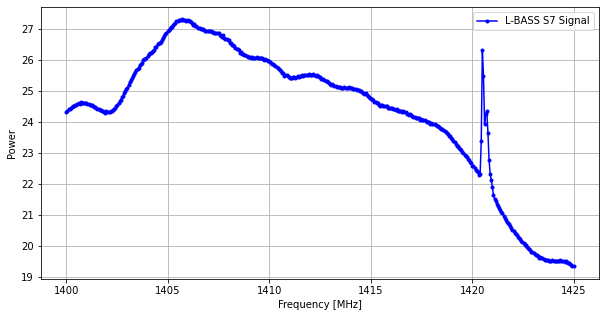

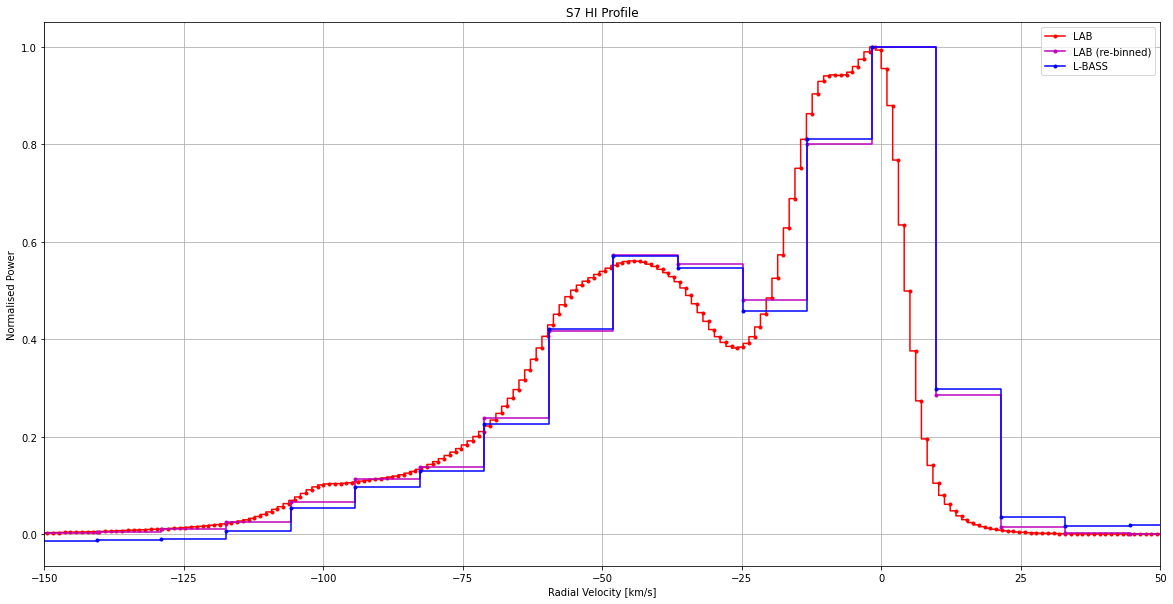

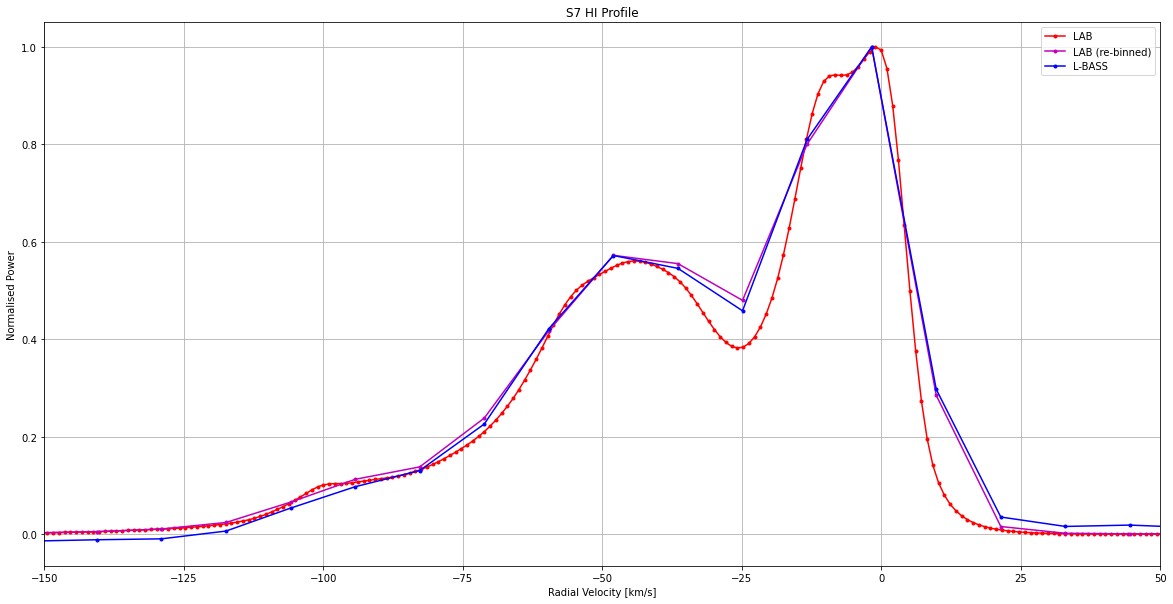

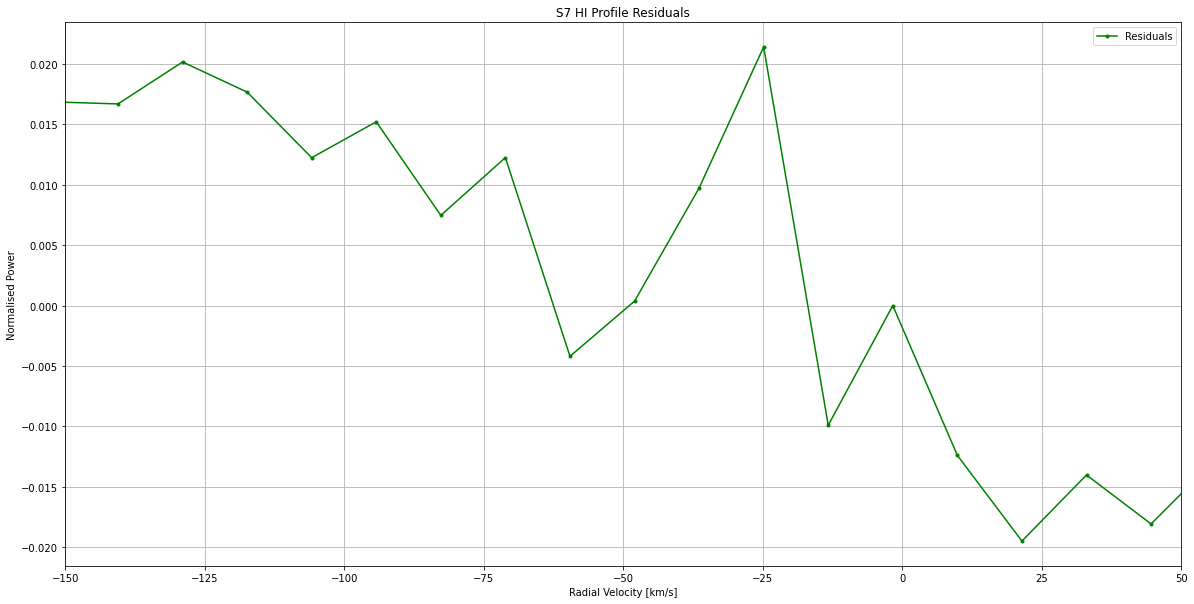

In [12]:
s7_transit = Transit('31st July 2024 - S7', 0, 60.32, 0, 'E', datetime.datetime(2024, 7, 31, 5, 36, 14))
s7_t, s7_pwr = s7_transit.get_data()

s7_pwr_trim = s7_pwr[:,19:21,:]

freq = np.linspace(1400, 1425, 457)

s7_bandpass = np.empty(718)

for i in range(0,718):
    s7_bandpass[i] = np.sum(s7_pwr_trim[0][:,i])

bandpass = np.concatenate((s7_bandpass[:480], np.linspace(0,0,21), s7_bandpass[501:]))

zero_indices = np.where(bandpass == 0)[0]

non_zero_indices = np.where(bandpass != 0)[0]

cubic_spline = scipy.interpolate.CubicSpline(non_zero_indices, bandpass[non_zero_indices])
bandpass[zero_indices] = cubic_spline(zero_indices)

s7_profile = (s7_bandpass-bandpass)[112:569]

plt.figure(figsize=(10, 5))
plt.plot(freq, s7_bandpass[112:569], marker=".", color='b', label="L-BASS S7 Signal")
#plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
#plt.title("Baseline Subtraction")
plt.show()

#hydrogen_line = np.where(s7_profile == np.max(s7_profile))[0] / 718 * 25 + 1400
hydrogen_line = 1420.405751786

vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + s7_lsr_corr

lab_rebinned = np.empty(len(vel))
width = ((vel[1]-vel[0])/2).value

for i in range(len(vel)):
    rhs = int(np.where(s7_lab_vel == find_nearest(s7_lab_vel, vel[i].value-width))[0])
    lhs = int(np.where(s7_lab_vel == find_nearest(s7_lab_vel, vel[i].value+width))[0])
    lab_rebinned[i] = np.sum(s7_lab_pwr[lhs-1:rhs])

plt.figure(figsize=(20, 10))
plt.step(s7_lab_vel, s7_lab_pwr, marker=".", color='r', label="LAB")
plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
plt.step(vel,s7_profile/np.max(s7_profile), marker=".", color='b', label="L-BASS")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("S7 HI Profile")
plt.xlim(-150,50)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(s7_lab_vel, s7_lab_pwr, marker=".", color='r', label="LAB")
plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
plt.plot(vel,s7_profile/np.max(s7_profile), color='b', marker=".", label="L-BASS")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("S7 HI Profile")
plt.xlim(-150,50)
plt.show()

residuals = -(s7_profile/np.max(s7_profile)-lab_rebinned/np.max(lab_rebinned))

plt.figure(figsize=(20, 10))
plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("S7 HI Profile Residuals")
plt.xlim(-150,50)
plt.show()

Ideal Velocity Correction

s7_transit = Transit('31st July 2024 - S7', 0, 60.32, 0, 'E', datetime.datetime(2024, 7, 31, 5, 36, 14))
s7_t, s7_pwr = s7_transit.get_data()

s7_pwr_trim = s7_pwr[:,19:21,:]

freq = np.linspace(1400, 1425, 457)

s7_bandpass = np.empty(718)

for i in range(0,718):
    s7_bandpass[i] = np.sum(s7_pwr_trim[0][:,i])

bandpass = np.concatenate((s7_bandpass[:480], np.linspace(0,0,21), s7_bandpass[501:]))

zero_indices = np.where(bandpass == 0)[0]

non_zero_indices = np.where(bandpass != 0)[0]

cubic_spline = scipy.interpolate.CubicSpline(non_zero_indices, bandpass[non_zero_indices])
bandpass[zero_indices] = cubic_spline(zero_indices)

s7_profile = (s7_bandpass-bandpass)[112:569]

plt.figure(figsize=(10, 5))
plt.plot(freq, s7_bandpass[112:569], marker=".", color='b', label="L-BASS S7 Signal")
#plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
#plt.title("Baseline Subtraction")
plt.show()

#hydrogen_line = np.where(s7_profile == np.max(s7_profile))[0] / 718 * 25 + 1400
hydrogen_line = 1420.405751786
s7_lsr_corr = np.linspace(15,25,10000)*u.km/u.s
residuals = np.empty(10000)

for i in range(10000):
    vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + s7_lsr_corr[i]

    lab_rebinned = np.empty(len(vel))
    width = ((vel[1]-vel[0])/2).value

    for j in range(len(vel)):
        rhs = int(np.where(s7_lab_vel == find_nearest(s7_lab_vel, vel[j].value-width))[0])
        lhs = int(np.where(s7_lab_vel == find_nearest(s7_lab_vel, vel[j].value+width))[0])
        lab_rebinned[j] = np.sum(s7_lab_pwr[lhs-1:rhs])

    residuals[i] = np.average(np.abs(-(s7_profile/np.max(s7_profile)-lab_rebinned/np.max(lab_rebinned))))

print(s7_lsr_corr[np.argmin(residuals)])

vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + s7_lsr_corr[np.argmin(residuals)]

lab_rebinned = np.empty(len(vel))
width = ((vel[1]-vel[0])/2).value

for i in range(len(vel)):
    rhs = int(np.where(s7_lab_vel == find_nearest(s7_lab_vel, vel[i].value-width))[0])
    lhs = int(np.where(s7_lab_vel == find_nearest(s7_lab_vel, vel[i].value+width))[0])
    lab_rebinned[i] = np.sum(s7_lab_pwr[lhs-1:rhs])

plt.figure(figsize=(20, 10))
plt.step(s7_lab_vel, s7_lab_pwr, marker=".", color='r', label="LAB")
plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
plt.step(vel,s7_profile/np.max(s7_profile), marker=".", color='b', label="L-BASS")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("S7 HI Profile")
plt.xlim(-150,50)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(s7_lab_vel, s7_lab_pwr, marker=".", color='r', label="LAB")
plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
plt.plot(vel,s7_profile/np.max(s7_profile), color='b', marker=".", label="L-BASS")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("S7 HI Profile")
plt.xlim(-150,50)
plt.show()

residuals = -(s7_profile/np.max(s7_profile)-lab_rebinned/np.max(lab_rebinned))

plt.figure(figsize=(20, 10))
plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.legend()
plt.title("S7 HI Profile Residuals")
plt.xlim(-150,50)
plt.show()

In [13]:
lab_int = np.abs(np.sum(lab_rebinned/np.max(lab_rebinned) * np.diff(vel)[0]))
lb_int = np.abs(np.sum(s7_profile/np.max(s7_profile) * np.diff(vel)[0]))

print(lab_int, lb_int)
print(np.abs((lb_int-lab_int)/lb_int))

54.92790646698346 km / s 54.011085116694964 km / s
0.016974688590455703


In [14]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(f"data/{self.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        # a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

S6 and S8

In [15]:
lsr_corr = 19.11041104110411 * u.km/u.s

s6_transit = Transit('12th Aug 2024', 0, -2.42, 0, 'E', datetime.datetime(2024, 8, 12, 18, 15, 18)) #GBT LSRK 14.676 km/sec
s8_transit = Transit('13th Aug 2024', 0, -1.67, 0, 'E', datetime.datetime(2024, 8, 13, 8, 28, 43)) #GBT LSRK -4.567 km/sec

s6_t, s6_pwr = s6_transit.get_data()
s8_t, s8_pwr = s8_transit.get_data()

s6_pwr_trim = s6_pwr[:,73:75,:]
s8_pwr_trim = s8_pwr[:,56:58,:]

s6_pwr_trim[0, :,np.argmax(s6_pwr_trim[0,:,:])-3:np.argmax(s6_pwr_trim[0,:,:])+3] = 12
s8_pwr_trim[0, :,np.argmax(s8_pwr_trim[0,:,:])-3:np.argmax(s8_pwr_trim[0,:,:])+3] = 12

s6_lab = np.genfromtxt("data/hydrogen profiles/s6_lab.txt", skip_header=4)
s8_lab = np.genfromtxt("data/hydrogen profiles/s8_lab.txt", skip_header=4)

In [16]:
def profile(pwr_trim, lab, lsr_corr):

    freq = np.linspace(1400, 1425, 457)

    s_bandpass = np.empty(718)

    for i in range(0,718):
        s_bandpass[i] = np.sum(pwr_trim[0][:,i])

    bandpass = np.concatenate((s_bandpass[:475], np.linspace(0,0,12), s_bandpass[487:]))

    zero_indices = np.where(bandpass == 0)[0]

    non_zero_indices = np.where(bandpass != 0)[0]

    bandpass[zero_indices] = np.interp(zero_indices, non_zero_indices, bandpass[non_zero_indices])

    profile = (s_bandpass-bandpass)[112:569]

    plt.figure(figsize=(10, 5))
    plt.plot(freq, s_bandpass[112:569], marker=".", color='b', label="L-BASS Signal")
    plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Power')
    plt.grid(True)
    plt.legend()
    #plt.title("Baseline Subtraction")
    #plt.xlim(1410,1415)
    plt.show()

    #hydrogen_line = np.where(s7_profile == np.max(s7_profile))[0] / 718 * 25 + 1400
    hydrogen_line = 1420.405751786

    lab_vel = lab[:,0]
    lab_pwr = lab[:,1] / np.max(lab[:,1])

    vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr

    lab_rebinned = np.empty(len(vel))
    width = ((vel[1]-vel[0])/2).value

    for i in range(len(vel)):
        rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value-width))[0])
        lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value+width))[0])
        lab_rebinned[i] = np.sum(lab_pwr[lhs-1:rhs])

    plt.figure(figsize=(20, 10))
    plt.step(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.step(vel,profile/np.max(profile), marker=".", color='b', label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.plot(vel,profile/np.max(profile), color='b', marker=".", label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    residuals = -(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))

    plt.figure(figsize=(20, 10))
    plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile Residuals")
    plt.xlim(-150,50)
    plt.show()

In [17]:
def profile_optimum_vel(pwr_trim, lab):

    freq = np.linspace(1400, 1425, 457)

    s_bandpass = np.empty(718)

    for i in range(0,718):
        s_bandpass[i] = np.sum(pwr_trim[0][:,i])

    bandpass = np.concatenate((s_bandpass[:470], np.linspace(0,0,22), s_bandpass[492:]))

    zero_indices = np.where(bandpass == 0)[0]

    non_zero_indices = np.where(bandpass != 0)[0]

    bandpass[zero_indices] = np.interp(zero_indices, non_zero_indices, bandpass[non_zero_indices])

    profile = (s_bandpass-bandpass)[112:569]

    plt.figure(figsize=(10, 5))
    plt.plot(freq, s_bandpass[112:569], marker=".", color='b', label="L-BASS Signal")
    plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Power')
    plt.grid(True)
    plt.legend()
    #plt.title("Baseline Subtraction")
    #plt.xlim(1410,1415)
    plt.show()

    #hydrogen_line = np.where(s7_profile == np.max(s7_profile))[0] / 718 * 25 + 1400
    hydrogen_line = 1420.405751786
    lsr_corr = np.linspace(-25,25,10000)*u.km/u.s
    residuals = np.empty(10000)

    lab_vel = lab[:,0]
    lab_pwr = lab[:,1] / np.max(lab[:,1])

    for i in range(10000):
        vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr[i]

        lab_rebinned = np.empty(len(vel))
        width = ((vel[1]-vel[0])/2).value

        for j in range(len(vel)):
            rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[j].value-width))[0])
            lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[j].value+width))[0])
            lab_rebinned[j] = np.sum(lab_pwr[lhs-1:rhs])

        residuals[i] = np.average(np.abs(-(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))))

    print(lsr_corr[np.argmin(residuals)])

    vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr[np.argmin(residuals)]

    lab_rebinned = np.empty(len(vel))
    width = ((vel[1]-vel[0])/2).value

    for i in range(len(vel)):
        rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value-width))[0])
        lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value+width))[0])
        lab_rebinned[i] = np.sum(lab_pwr[lhs-1:rhs])

    plt.figure(figsize=(20, 10))
    plt.step(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.step(vel,profile/np.max(profile), marker=".", color='b', label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.plot(vel,profile/np.max(profile), color='b', marker=".", label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    residuals = -(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))

    plt.figure(figsize=(20, 10))
    plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile Residuals")
    plt.xlim(-150,50)
    plt.show()

    lab_int = np.abs(np.sum(lab_rebinned/np.max(lab_rebinned) * np.diff(vel)[0]))
    lb_int = np.abs(np.sum(profile/np.max(profile) * np.diff(vel)[0]))

    print(lab_int, lb_int)
    print(np.abs((lb_int-lab_int)/lb_int))

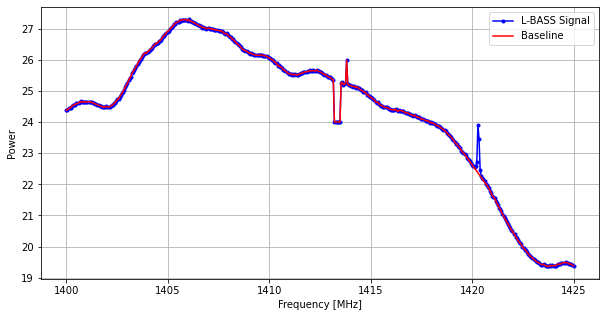

-19.71947194719472 km / s


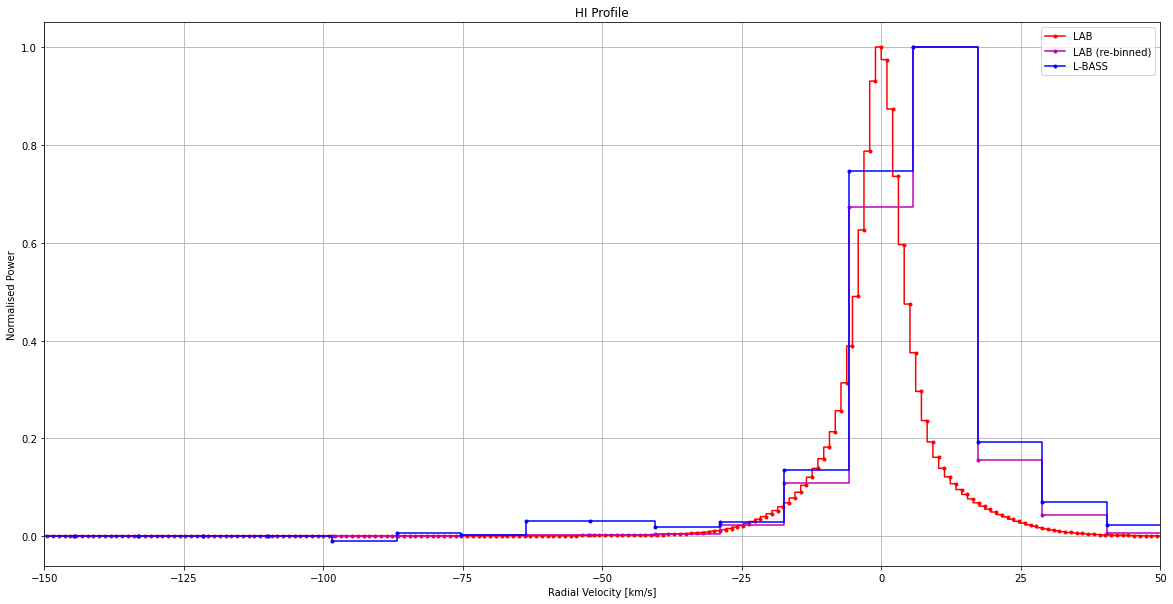

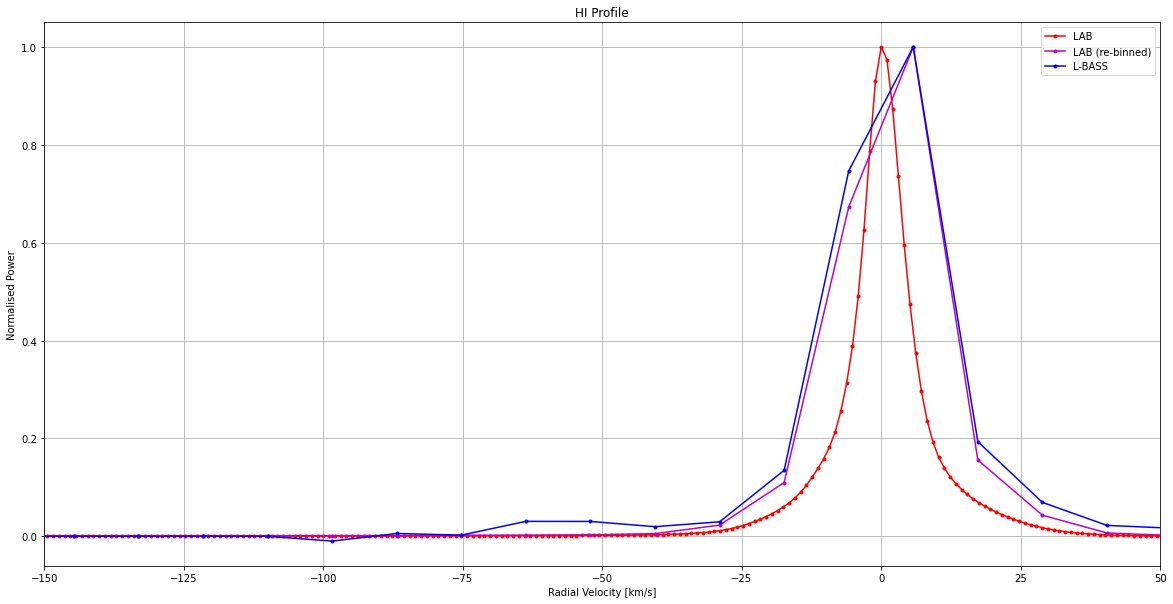

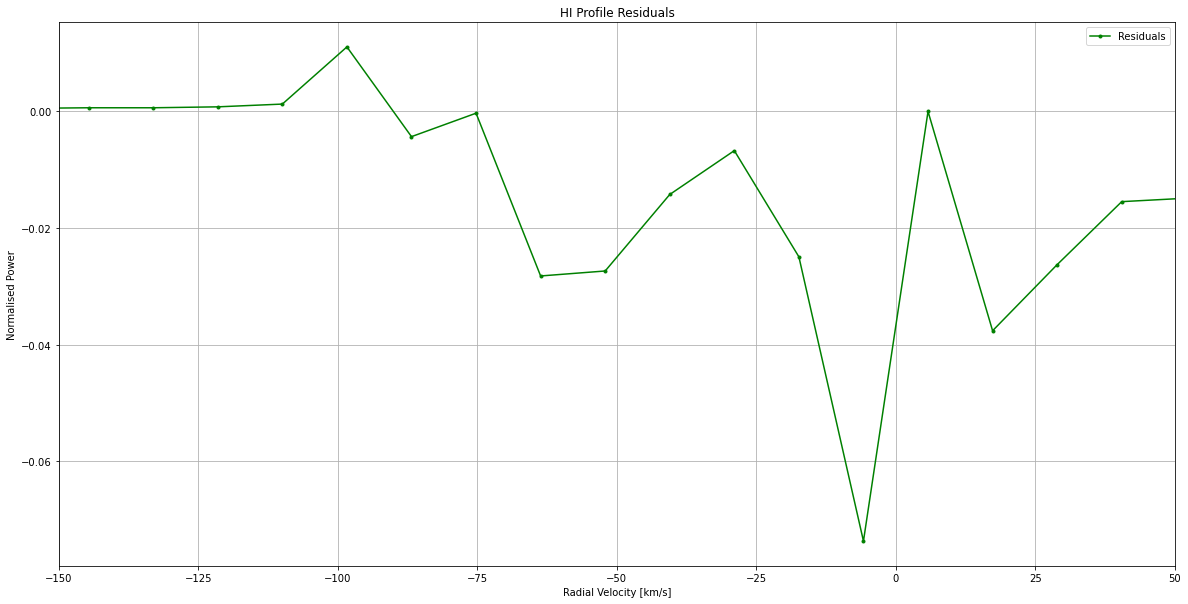

23.600746593744347 km / s 27.20868396412654 km / s
0.13260242116594467


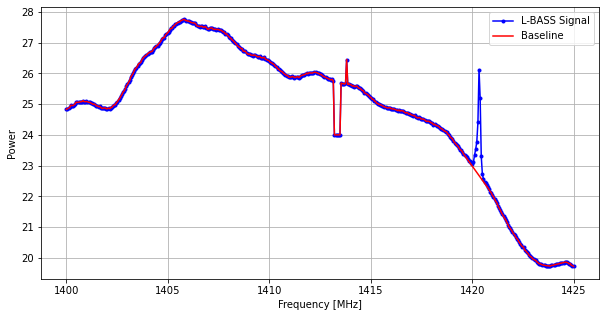

-0.14251425142514051 km / s


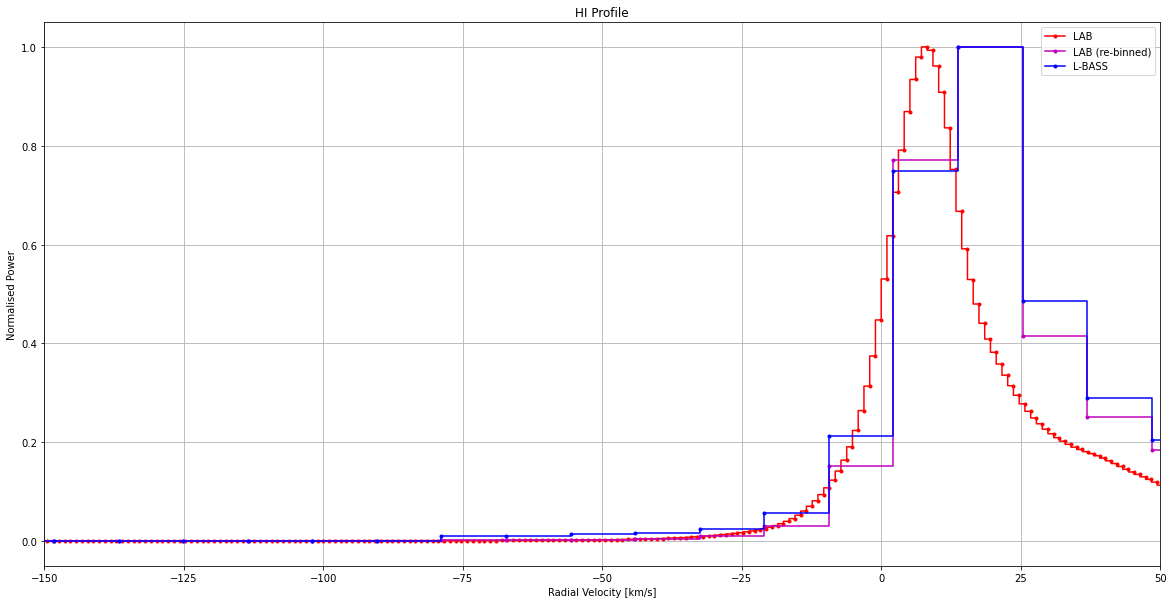

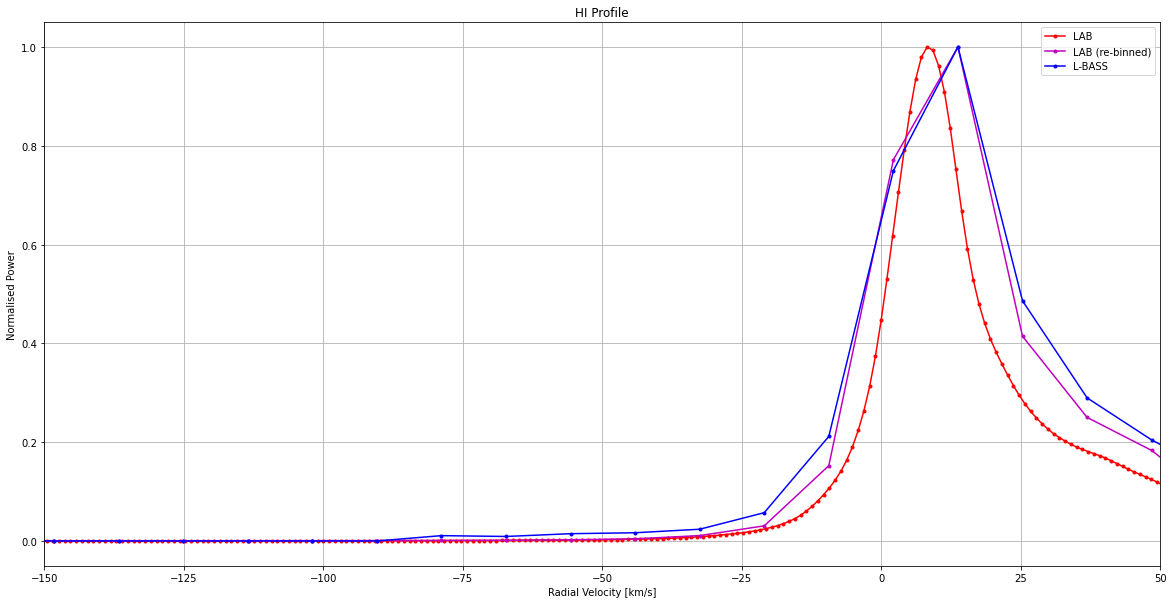

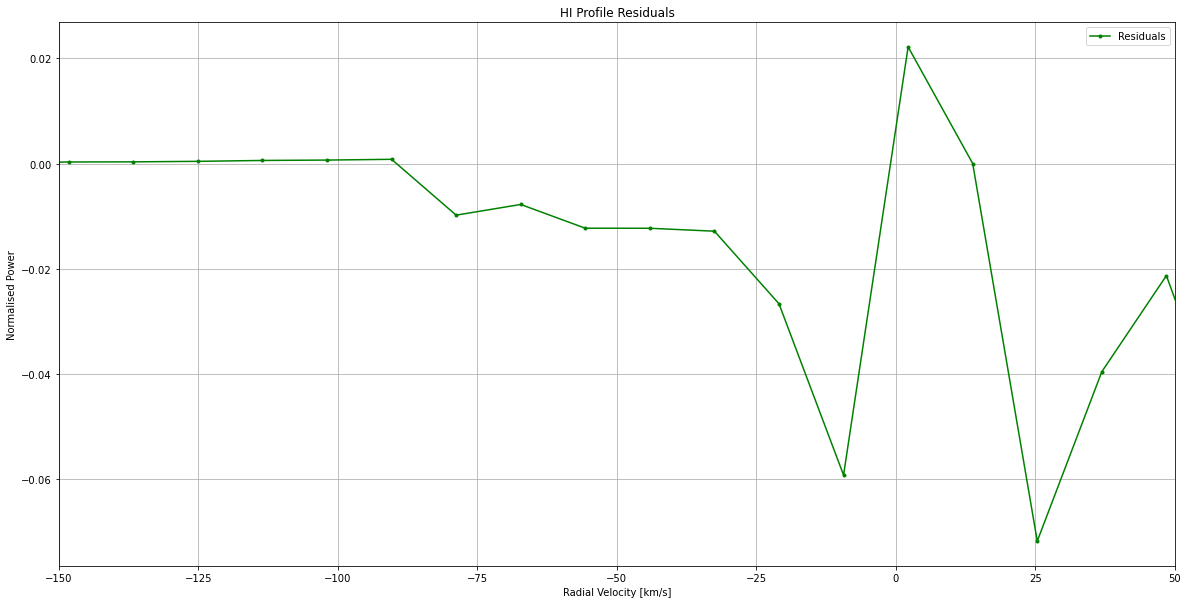

34.029072187516384 km / s 38.896936624214135 km / s
0.12514775864553318


In [18]:
profile_optimum_vel(s6_pwr_trim, s6_lab)
profile_optimum_vel(s8_pwr_trim, s8_lab)

Dec 42

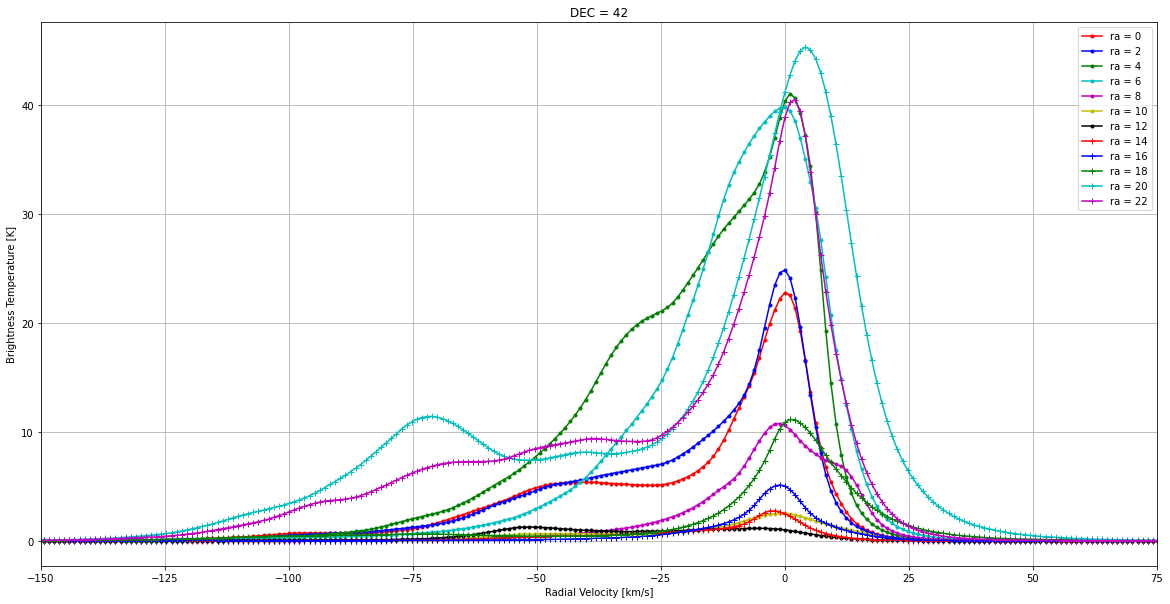

In [54]:
ra0 = np.genfromtxt("data/hydrogen profiles/dec42/ra0dec42.txt", skip_header=4)
ra2 = np.genfromtxt("data/hydrogen profiles/dec42/ra2dec42.txt", skip_header=4)
ra4 = np.genfromtxt("data/hydrogen profiles/dec42/ra4dec42.txt", skip_header=4)
ra6 = np.genfromtxt("data/hydrogen profiles/dec42/ra6dec42.txt", skip_header=4)
ra8 = np.genfromtxt("data/hydrogen profiles/dec42/ra8dec42.txt", skip_header=4)
ra10 = np.genfromtxt("data/hydrogen profiles/dec42/ra10dec42.txt", skip_header=4)
ra12 = np.genfromtxt("data/hydrogen profiles/dec42/ra12dec42.txt", skip_header=4)
ra14 = np.genfromtxt("data/hydrogen profiles/dec42/ra14dec42.txt", skip_header=4)
ra16 = np.genfromtxt("data/hydrogen profiles/dec42/ra16dec42.txt", skip_header=4)
ra18 = np.genfromtxt("data/hydrogen profiles/dec42/ra18dec42.txt", skip_header=4)
ra20 = np.genfromtxt("data/hydrogen profiles/dec42/ra20dec42.txt", skip_header=4)
ra22 = np.genfromtxt("data/hydrogen profiles/dec42/ra22dec42.txt", skip_header=4)

vel = ra0[:,0]

ra0_pwr = ra0[:,1]
ra2_pwr = ra2[:,1]
ra4_pwr = ra4[:,1]
ra6_pwr = ra6[:,1]
ra8_pwr = ra8[:,1]
ra10_pwr = ra10[:,1]
ra12_pwr = ra12[:,1]
ra14_pwr = ra14[:,1]
ra16_pwr = ra16[:,1]
ra18_pwr = ra18[:,1]
ra20_pwr = ra20[:,1]
ra22_pwr = ra22[:,1]

plt.figure(figsize=(20, 10))
plt.plot(vel, ra0_pwr, marker=".", color='r', label="ra = 0")
plt.plot(vel, ra2_pwr, marker=".", color='b', label="ra = 2")
plt.plot(vel, ra4_pwr, marker=".", color='g', label="ra = 4")
plt.plot(vel, ra6_pwr, marker=".", color='c', label="ra = 6")
plt.plot(vel, ra8_pwr, marker=".", color='m', label="ra = 8")
plt.plot(vel, ra10_pwr, marker=".", color='y', label="ra = 10")
plt.plot(vel, ra12_pwr, marker=".", color='k', label="ra = 12")
plt.plot(vel, ra14_pwr, marker="+", color='r', label="ra = 14")
plt.plot(vel, ra16_pwr, marker="+", color='b', label="ra = 16")
plt.plot(vel, ra18_pwr, marker="+", color='g', label="ra = 18")
plt.plot(vel, ra20_pwr, marker="+", color='c', label="ra = 20")
plt.plot(vel, ra22_pwr, marker="+", color='m', label="ra = 22")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Brightness Temperature [K]')
plt.grid(True)
plt.legend()
plt.title("DEC = 42")
plt.xlim(-150,75)
#plt.ylim(0,6)
plt.show()

NCP

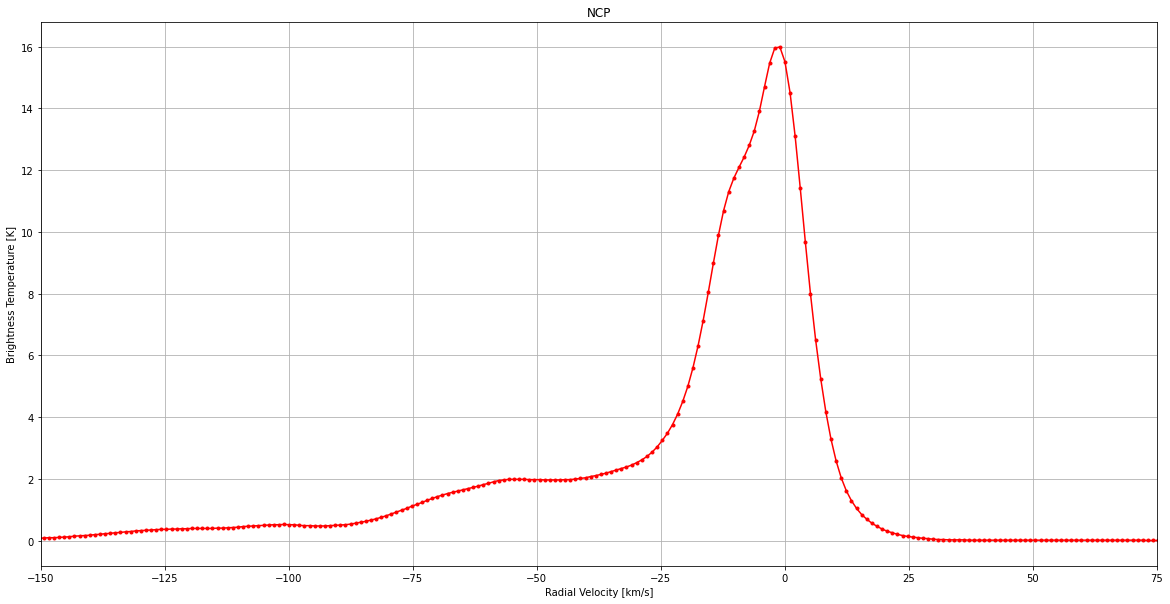

In [55]:
ncp = np.genfromtxt("data/hydrogen profiles/ncp.txt", skip_header=4)

vel = ncp[:,0]

ncp_pwr = ncp[:,1]

plt.figure(figsize=(20, 10))
plt.plot(vel, ncp_pwr, marker=".", color='r', label="ncp")
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Brightness Temperature [K]')
plt.grid(True)
#plt.legend()
plt.title("NCP")
plt.xlim(-150,75)
#plt.ylim(0,6)
plt.show()